In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [3]:
df_train = pd.read_csv('dataset-emotion/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('dataset-emotion/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('dataset-emotion/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

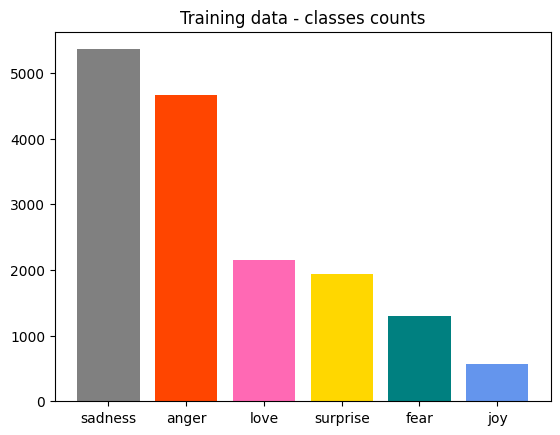

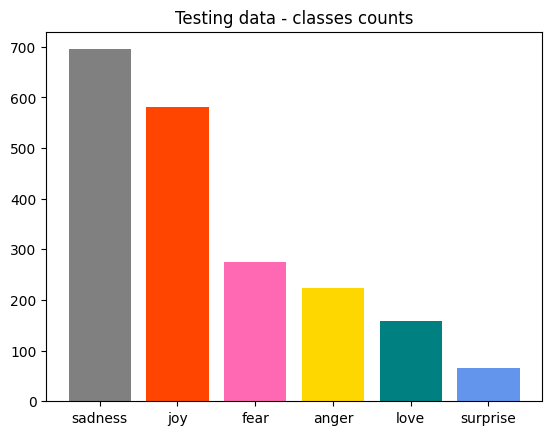

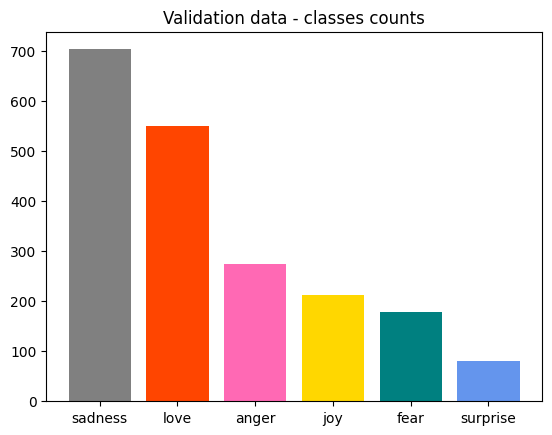

In [4]:
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [5]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [8]:
path_to_glove_file = 'glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [9]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 lstm (LSTM)                 (None, 256, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 3,455,246
Trainable params: 218,246
Non-trainable params: 3,237,000
_________________________________________________________________


In [10]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [11]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
63/63 [==============================] - 788s 12s/step - loss: 1.4077 - accuracy: 0.4490 - val_loss: 0.9340 - val_accuracy: 0.6765
Epoch 2/10
63/63 [==============================] - 748s 12s/step - loss: 0.6547 - accuracy: 0.7676 - val_loss: 0.3851 - val_accuracy: 0.8650
Epoch 3/10
63/63 [==============================] - 867s 14s/step - loss: 0.3472 - accuracy: 0.8766 - val_loss: 0.2751 - val_accuracy: 0.8955
Epoch 4/10
63/63 [==============================] - 1048s 17s/step - loss: 0.2388 - accuracy: 0.9081 - val_loss: 0.2190 - val_accuracy: 0.9055
Epoch 5/10
63/63 [==============================] - 1192s 19s/step - loss: 0.1840 - accuracy: 0.9236 - val_loss: 0.1734 - val_accuracy: 0.9215
Epoch 6/10
63/63 [==============================] - 1280s 20s/step - loss: 0.1442 - accuracy: 0.9343 - val_loss: 0.1647 - val_accuracy: 0.9250
Epoch 7/10
63/63 [==============================] - 1324s 21s/step - loss: 0.1388 - accuracy: 0.9369 - val_loss: 0.1611 - val_accuracy: 0.9205
Ep

In [12]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 12s 193ms/step - loss: 0.1436 - accuracy: 0.9355


[0.14361757040023804, 0.9355000257492065]

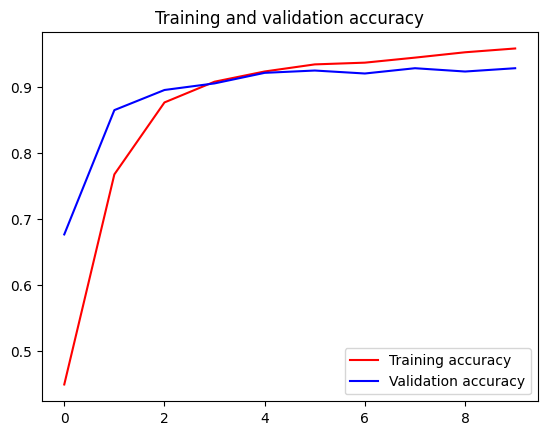

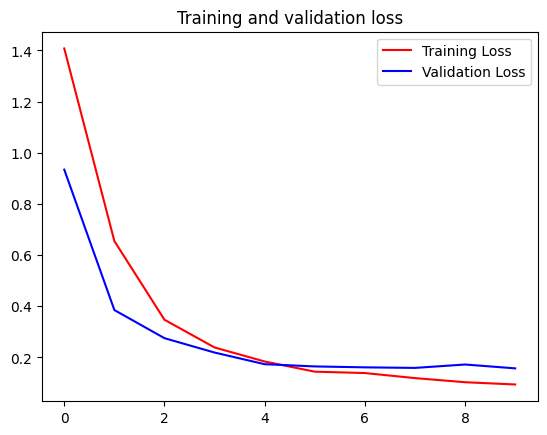

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 0s 141ms/step
joy : 0.9737917184829712


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 0s 165ms/step
anger : 0.6283922791481018


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 0s 199ms/step
sadness : 0.3574797213077545


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 0s 167ms/step
surprise : 0.5615928769111633




In [15]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')

In [19]:
import numpy as np
import pickle
import re
import string
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

with open('labelEncoder.pickle', 'rb') as f:
    le = pickle.load(f)

model = load_model('Emotion Recognition.h5')

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text  

def preprocess_input(text):
    cleaned_text = clean(text)
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])
    padded_text = pad_sequences(tokenized_text, maxlen=256, truncating='pre')
    return padded_text

def predict_emotion(text):
    processed_text = preprocess_input(text)
    predicted_proba = model.predict(processed_text)[0]
    predicted_class_index = np.argmax(predicted_proba)
    predicted_class = le.inverse_transform([predicted_class_index])[0]
    confidence_score = predicted_proba[predicted_class_index]
    confidence_scores = {le.inverse_transform([i])[0]: proba * 100 for i, proba in enumerate(predicted_proba)}
    return predicted_class, confidence_score, confidence_scores

user_input = input("Masukkan kalimat: ")
emotion, confidence, confidence_scores = predict_emotion(user_input)
print(f"Prediksi Emosi: {emotion} dengan tingkat kepercayaan {confidence:.3f}%")
print("Tingkat kepercayaan untuk masing-masing kelas:")
for emotion, score in confidence_scores.items():
    print(f"{emotion}: {score:.3f}%")

1/1 [==============================] - 1s 660ms/step
Prediksi Emosi: anger dengan tingkat kepercayaan 0.935%
Tingkat kepercayaan untuk masing-masing kelas:
anger: 93.480%
fear: 3.178%
joy: 1.024%
love: 0.099%
sadness: 2.156%
surprise: 0.063%


In [20]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
import numpy as np
import pickle
import re
import string
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

with open('labelEncoder.pickle', 'rb') as f:
    le = pickle.load(f)

model = load_model('Emotion Recognition.h5')

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text  

def preprocess_input(text):
    cleaned_text = clean(text)
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])
    padded_text = pad_sequences(tokenized_text, maxlen=256, truncating='pre')
    return padded_text

def predict_emotion(text):
    processed_text = preprocess_input(text)
    predicted_proba = model.predict(processed_text)[0]
    predicted_class_index = np.argmax(predicted_proba)
    predicted_class = le.inverse_transform([predicted_class_index])[0]
    confidence_score = predicted_proba[predicted_class_index]
    confidence_scores = {le.inverse_transform([i])[0]: proba * 100 for i, proba in enumerate(predicted_proba)}
    return predicted_class, confidence_score, confidence_scores

def predict_and_show():
    user_input = entry.get()
    if user_input.strip() == "":
        messagebox.showerror("Error", "Masukkan kalimat terlebih dahulu!")
        return
    emotion, confidence, confidence_scores = predict_emotion(user_input)
    result_label.config(text=f"Prediksi Emosi: {emotion} ({confidence:.3f}%)")
    result_text.delete(1.0, tk.END)
    for emotion, score in confidence_scores.items():
        result_text.insert(tk.END, f"{emotion}: {score:.3f}%\n")

root = tk.Tk()
root.title("Emotion Recognition")
root.geometry("400x300")

label = ttk.Label(root, text="Masukkan Kalimat:")
label.pack(pady=10)

entry = ttk.Entry(root, width=40)
entry.pack(pady=5)

predict_button = ttk.Button(root, text="Prediksi", command=predict_and_show)
predict_button.pack(pady=5)

result_label = ttk.Label(root, text="")
result_label.pack(pady=5)

result_text = tk.Text(root, height=5, width=40)
result_text.pack(pady=5)

root.mainloop()

1/1 [==============================] - 0s 136ms/step
